In [2]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import time
from datetime import datetime
from My_RLBase import *
import gymnasium as gym
import numpy as np
import copy
import imageio

In [3]:
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")

Device set to : NVIDIA GeForce GTX 1650


In [4]:
################################## RolloutBuffer ##################################
class RolloutBuffer:                   # Mermory，用于存储行为网络（演员）的采样结果。
    def __init__(self):
        self.actions = []        
        self.states = []
        self.log_probs = [] 
        self.rewards = [] 
        self.state_values = []          # critic网络的估计值
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]            # del 关键字删除
        del self.states[:]
        del self.log_probs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super().__init__()

        self.has_continuous_action_space = has_continuous_action_space
        
        if has_continuous_action_space:              # 是否具有连续的动作空间。
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
                                                     # full用于创建指定形状（shape）的张量，并用指定的标量值（fill_value）填充整个张量。
        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(                       # 使用Sequential创建时，不需要定义forward方法，因为它默认按顺序执行。
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),        # 拥有连续动作空间的话，输出的不归一化
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # critic
        self.critic = nn.Sequential(                 # critic网络，用于拟合折扣奖励，最后会趋近于该s下采取动作得到回报的均值。 
                        nn.Linear(state_dim, 64),    # 将实际的Return - Ctritic,即可得出该动作的相对好坏; 这样可以帮助在某一状态中选出更好的动作
                        nn.Tanh(),                   # 类似于添加baseline，但是这个更加好用，相当于每个状态s下都有一个自己的baseline，更能加快模型收敛。
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)             # 只输出一个值，作为对当前s下所采取a的评估
                    )
        
    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError
    
    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)                            # 连续动作空间中，网络的输出当作了该动作的期望值。
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)     # 创建协方差矩阵；对角线元素全一致； 并且又加了一维
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)                             # 离散动作空间的话，直接softmax归一，然后根据不同概率值取样。
            dist = Categorical(action_probs)

        action = dist.sample()                      # action是actor网络得出的
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)              # critic网络评价。 state_value，价值就是回报的均值！！

        return action.detach(), action_logprob.detach(), state_val.detach()  # 分离出标量值;分别为选取的动作、对数概率、
    
    def evaluate(self, state, action):                               

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_log_probs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_log_probs, state_values, dist_entropy

In [56]:
class PPO:
    def __init__(self, s_size, a_size, lr_actor, lr_critic, gamma, epochs, max_steps, update_times, update_steps, eps_clip, has_continuous_action_space, print_freq = 10, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:              # 如果是连续的动作空间的话
            self.action_std = action_std_init

        self.action_std_init = action_std_init
        self.s_size = s_size
        self.a_size = a_size
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        self.epochs = epochs
        self.max_steps = max_steps
        self.update_times = update_times
        self.update_steps = update_steps
        self.eps_clip = eps_clip      # 采用的是clip的PPO
        self.print_freq = print_freq
        self.buffer = RolloutBuffer()


        self.policy = ActorCritic(self.s_size, self.a_size, self.has_continuous_action_space, self.action_std_init).to(device)
        self.actor_optimizer = torch.optim.Adam(self.policy.actor.parameters(), self.lr_actor)# 演员的网络
        self.critic_optimizer =  torch.optim.Adam(self.policy.critic.parameters(), self.lr_critic) # critic网络

        self.policy_old = ActorCritic(self.s_size, self.a_size, self.has_continuous_action_space, self.action_std_init).to(device)   # 再创建一个新的实例
        self.policy_old.load_state_dict(self.policy.state_dict())   # PolicyGradient.ipynbcy.state_dict()获取模型的所有参数； load_state_dict将参数字典加载到模型中；
                                                                    # 这样的话就保证了初始policy和policy_old的参数是相同的
        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):                    # 连续动作空间下重新设置分布的方差
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):           # 动作空间方差衰减
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def act(self, state):
        state = torch.FloatTensor(state).to(device)
        if self.has_continuous_action_space:
            with torch.no_grad():
                action_mean = self.policy_old.actor(state)                      # 连续动作空间中，网络的输出当作了该动作的期望值。
                cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)          # 创建协方差矩阵；对角线元素全一致； 并且又加了一维
                dist = MultivariateNormal(action_mean, cov_mat)                                       
        else:
            with torch.no_grad():                                                  #  torch.no_grad() 上下文管理器，标识代码块中的计算不需要梯度；
                action_probs = self.policy_old.actor(state)                        # 离散动作空间的话，直接softmax归一，然后根据不同概率值取样。
                dist = Categorical(action_probs)

        action = dist.sample()                                # action是actor网络得出的
        action_logprob = dist.log_prob(action)
        state_val = self.policy_old.critic(state)             # critic网络评价。 state_value，价值就是回报的均值！！

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.log_probs.append(action_logprob)
        self.buffer.state_values.append(state_val)
        
        if self.has_continuous_action_space:
            return action.detach().cpu().numpy().flatten()     # 这时返回的是一个列表数据
        else:
            return action.item()         

    def update(self):                          # old_policy采集多轮后的数据用于更新
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):   # 从policy_old中取结果
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)                                   # 动态规划求return
            rewards.insert(0, discounted_reward)                    
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)      # 在这一步把值变为张量； 移到gpu上会默认带有梯度信息
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)      # torch.squeeze 去除尺寸大小为 1 的维度,像[[[1,2,3]]]这种,会变成[1,2,3]
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)    # torch.stack 按照dim指定的维度堆叠张量
        old_log_probs = torch.squeeze(torch.stack(self.buffer.log_probs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()      # 回报 - critic的拟合价值， 求出优势函数的值

        # Optimize policy for update_times epochs
        for _ in range(self.update_times):

            # Evaluating old actions and values
            log_probs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)  # 这里是用policy做的
                                                                                                   # old_policy采样，新的policy评估
            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(log_probs - old_log_probs.detach())                         ## 重要性权重，因为求的是对数概率，所以这里加了exp
                                                                                           # old_policy用于采集，然后policy对采集的结果也评价一次，得出两者的比值，即用作重要性权重来修正分布差异
            # Finding Surrogate Loss  
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages   # torch.clamp 将张量中的元素限制在指定范围内的函数
            
            # final loss of clipped objective PPO
            actor_loss = -torch.min(surr1, surr2).mean() # + 0.01 * dist_entropy.mean()   # 控制到上下界范围，更新策略网络和演员网络不能相差太大
            critic_loss = 0.5 * self.MseLoss(state_values, rewards.detach()).mean()
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())       # 更新完的参数同步到policy_old网络中，  critic也同步更新
        
        # clear buffer
        self.buffer.clear()                                             # 清空buffer
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

################################### Training ###################################
def train(env, agent):
    print_freq = agent.print_freq       # print avg reward in the interval (in num timesteps)
    rewards = []
    actor_losses = []
    critic_losses = []
    action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
    min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
    action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)
    ###################################################
    #####################################################
    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)
    print("============================================================================================")

    print_running_reward = 0
    print_running_episodes = 0
    
    time_step = 0     # 记录走了多少步

    scores = []
    best_ep_reward = 0
    
    for i_episode in range(1, agent.epochs+1):
        
        state = env.reset()[0]
        current_ep_reward = 0

        for t_step in range(1, agent.max_steps+1):

            # select action with policy
            action = agent.act(state)
            state, reward, done, _, _ = env.step(action)

            # saving reward and is_terminals
            agent.buffer.rewards.append(reward)
            agent.buffer.is_terminals.append(done)

            time_step +=1
            current_ep_reward += reward

            # update PPO agent
            if time_step % agent.update_steps == 0:    # 每update_timestep次，更新一次
                agent.update()

            # if continuous action space; then decay action std of ouput action distribution
            if agent.has_continuous_action_space and time_step % action_std_decay_freq == 0:
                agent.decay_action_std(action_std_decay_rate, min_action_std)

            # break; if the episode is over
            if done:
                break
            
        # printing average reward
        if i_episode % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes   # 累计print_freq的reward除以epoch轮数
            print_avg_reward = round(print_avg_reward, 2)

            print(f"Episode : {i_episode} \t\t Timestep : {time_step} \t\t Average Reward : {print_avg_reward}")

            if print_avg_reward >= best_ep_reward:
                best_ep_reward = print_avg_reward
                best_policy = copy.deepcopy(agent.policy)
                print(f'==========================Best_agent has changed, the best reward is {best_ep_reward}======================')
                
            print_running_reward = 0
            print_running_episodes = 0
            
        print_running_reward += current_ep_reward
        print_running_episodes += 1
        epoch_rewards.append(current_ep_reward)
        
    instance_params = agent.__dict__                        # 复制，连浅拷贝都不是，所以下列的删除操作会把agent的属性一起删除。
    del instance_params['policy'], instance_params['buffer'], instance_params['policy_old'],  instance_params['actor_optimizer'], instance_params['critic_optimizer'], instance_params['MseLoss']
    best_agent = PPO(**instance_params)                      # 通过 **kwargs 创建具有相同参数的新实例
    best_agent.policy_old.load_state_dict(best_policy.state_dict())
    env.close()
    return best_agent, rewards, actor_losses, critic_losses
    # print total training time
    print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    print("Total training time  : ", end_time - start_time)

In [51]:
def test(env, best_agent, test_epochs):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(test_epochs):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()[0]  # 重置环境，返回初始状态
        for _ in range(best_agent.max_steps):
            ep_step += 1
            action = best_agent.act(state)  # 选择动作
            next_state, reward, done, _, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{test_epochs}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

In [75]:
type(agent).__name__ == 'PPO'

True

In [52]:
env = gym.make('CartPole-v1')
a_size = env.action_space.n
s_size = env.observation_space.shape[0]

In [57]:
 # initialize a PPO agent
epoch_rewards = []
actor_losses = []
critic_losses = []
agent = PPO(s_size, a_size, lr_actor = 3e-3, lr_critic = 3e-4, gamma = 0.99, epochs = 600, max_steps = 500, update_times = 20,  update_steps = 2000, eps_clip = 0.2, has_continuous_action_space = False)

In [58]:
best_agent = train(env, agent)

Started training at (GMT) :  2023-11-28 17:03:23
Episode : 10 		 Timestep : 157 		 Average Reward : 15.44
==========================Best_agent has changed, the best reward is 15.44======================
Episode : 20 		 Timestep : 338 		 Average Reward : 18.0
==========================Best_agent has changed, the best reward is 18.0======================
Episode : 30 		 Timestep : 559 		 Average Reward : 22.8
==========================Best_agent has changed, the best reward is 22.8======================
Episode : 40 		 Timestep : 722 		 Average Reward : 16.1
Episode : 50 		 Timestep : 889 		 Average Reward : 17.0
Episode : 60 		 Timestep : 1033 		 Average Reward : 13.4
Episode : 70 		 Timestep : 1202 		 Average Reward : 17.8
Episode : 80 		 Timestep : 1421 		 Average Reward : 21.2
Episode : 90 		 Timestep : 1655 		 Average Reward : 24.0
==========================Best_agent has changed, the best reward is 24.0======================
Episode : 100 		 Timestep : 1836 		 Average Reward : 17.7

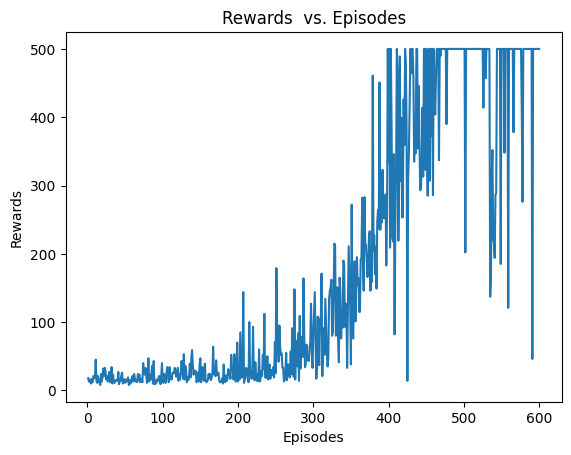

In [59]:
plot_scores(epoch_rewards)

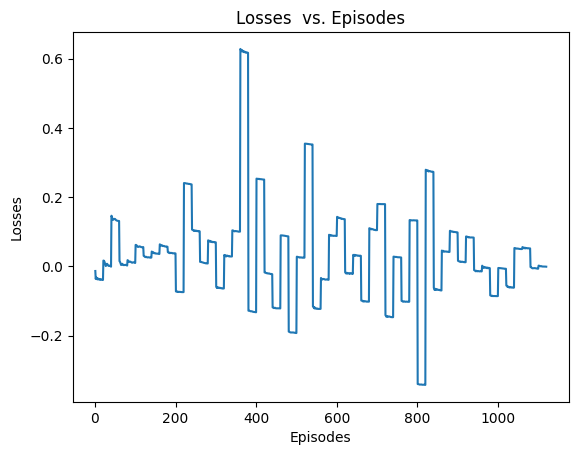

In [60]:
plot_losses(actor_losses)

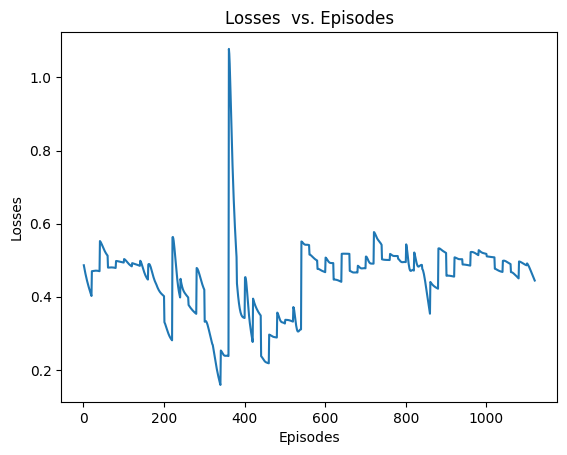

In [61]:
plot_losses(critic_losses)

In [62]:
test(env, best_agent, 20)

开始测试！
回合：1/20，奖励：500.00
回合：2/20，奖励：500.00
回合：3/20，奖励：500.00
回合：4/20，奖励：500.00
回合：5/20，奖励：162.00
回合：6/20，奖励：500.00
回合：7/20，奖励：500.00
回合：8/20，奖励：443.00
回合：9/20，奖励：500.00
回合：10/20，奖励：500.00
回合：11/20，奖励：500.00
回合：12/20，奖励：500.00
回合：13/20，奖励：500.00
回合：14/20，奖励：500.00
回合：15/20，奖励：500.00
回合：16/20，奖励：302.00
回合：17/20，奖励：500.00
回合：18/20，奖励：500.00
回合：19/20，奖励：500.00
回合：20/20，奖励：500.00
完成测试


{'rewards': [500.0,
  500.0,
  500.0,
  500.0,
  162.0,
  500.0,
  500.0,
  443.0,
  500.0,
  500.0,
  500.0,
  500.0,
  500.0,
  500.0,
  500.0,
  302.0,
  500.0,
  500.0,
  500.0,
  500.0]}

In [27]:
def record_video(env, policy, out_directory, fps=30):
    images = []
    terminated = False
    truncated = False
    state = env.reset()
    state = state[0]
    img = env.render()
    images.append(img)
    while not terminated and not truncated:
        action = policy.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [28]:
vedio_env = gym.make("CartPole-v1", render_mode="rgb_array")
video_path = './PPO_CartPole_v1_Replay.mp4'
record_video(vedio_env, best_agent, video_path, 30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [71]:
policy_para = best_agent.policy_old.state_dict()
torch.save(policy_para, './Game_models/PPO_CartPole-v1_500.pth')

In [2]:
import torch
torch.FloatTensor(63)

tensor([7.1447e+31, 2.2266e-15, 1.7753e+28, 4.4868e+21, 4.4650e+30, 1.7753e+28,
        3.3645e-15, 7.3988e+31, 4.4849e+21, 2.7370e+20, 6.4640e-04, 1.8461e+20,
        9.0941e-04, 2.6223e+20, 1.7465e+19, 1.8888e+31, 7.2347e+11, 2.7253e+20,
        3.4550e-12, 1.4583e-19, 1.0899e+27, 6.8943e+34, 1.6212e-19, 3.0881e+29,
        6.3828e+28, 1.4603e-19, 7.7179e+28, 1.6217e-19, 7.7180e+28, 7.9463e+08,
        3.2604e-12, 1.1625e+33, 8.9605e-01, 1.1632e+33, 5.6003e-02, 7.0374e+22,
        6.9983e+28, 1.6214e-19, 1.7179e+19, 7.3471e+28, 7.9471e+08, 5.0944e-14,
        1.6109e-19, 1.8888e+31, 1.1727e-19, 7.2128e+22, 1.4755e+31, 2.7253e+20,
        7.2126e+22, 4.7428e+30, 7.7781e+31, 2.6209e+20, 2.0530e-19, 1.4226e-13,
        6.2608e+22, 4.7428e+30, 3.5833e-14, 7.7781e+31, 1.6907e-01, 1.7743e+28,
        1.3458e-14, 8.1433e-33, 8.1371e-33])

In [4]:
torch.tensor(63).float()

tensor(63.)

In [7]:
torch.tensor(63, dtype=float32)

NameError: name 'float32' is not defined

In [18]:
a = []
torch.tensor(a)

tensor([])

In [19]:
a.append(1)

In [20]:
type(a)

list

In [22]:
a = enumerate([1,2,3])

In [25]:
for i,j in a:
    print(i ,j )

0 1
1 2
2 3
